## 1. Import Modules and Data
Accroding to original paper <a href="https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf">Improving Language Understanding by Generative Pre-Training</a>, GPT is pretrained on bookcorpus dataset, described by [Zhu and Kiros et al](https://yknzhu.wixsite.com/mbweb). You can learn more from [here](https://huggingface.co/datasets/bookcorpus/bookcorpus) and download from [this branch](https://huggingface.co/datasets/bookcorpus/bookcorpus/tree/refs%2Fconvert%2Fparquet/plain_text/train).

The full BookCorpus dataset is too large, so we only use 10% of it for pre-training as examples. In `load_data`, all plain text will be tokenized and converted to token id with BPE algorithm. Finally, a data loader will be returned where each batch is token ids tensor with shape `[batch_size, max_len]`.

In [4]:
import config
from data import load_data


# only use 1% BookCorpus dataset
loading_ratio = 0.01

tokenizer, dataloader = load_data("bookcorpus", loading_ratio=loading_ratio, num_proc=5)

total_steps = (
    len(dataloader) * config.PretrainConfig.n_epoch // config.PretrainConfig.update_freq
)

# scale warmup steps
warmup_steps = int(
    config.PretrainConfig.warmup_steps
    * loading_ratio
    // config.PretrainConfig.update_freq
)

total_steps, warmup_steps

Downloaded at  [/home/jyc/.cache/huggingface/datasets/downloads/4ae3271c145b7cf080a16f6a2e0fa1d6410e16d8e50c32966328a2b721cf86a4.cfcd7c0ef3521898b77bd4829f8599ad4bc97b70065998fbda8f675af882a783 (origin=https://hf-mirror.com/datasets/bookcorpus/bookcorpus/resolve/refs%2Fconvert%2Fparquet/plain_text/train/0000.parquet?download=true)]


Map (num_proc=5):   0%|          | 0/740042 [00:00<?, ? examples/s]

(1156275, 5)

## 2. Build Model

I've pointed out key structure differences between GPT and vanilla transformer in [README](./README.md), but I still want to highlight that the GeLU used in feed forward layers in decoder block is approximate with `tanh`.

In [ ]:
import torch
import config
from modules import GPT

device = torch.device("cuda:1")
model = GPT(
    vocab_size=config.vocab_size,
    max_len=config.max_len,
    d_model=config.d_model,
    n_head=config.n_head,
    n_layer=config.n_layer,
    dropout=config.dropout,
).to(device)

## 3. Pretrain Model
We have set most hyper parameters in [config.py](./config.py), two last things are explore optimizer and scheduler we used.

### 3.1 Optimizer
We won't use `AdamW` as optimizer directly. Instead, we should filter out those gain weights, e.g. weights and bias of `LayerNorm`, and biases to make sure they won't be applied weight decay, see `GPT.configure_optimizer()`.

### 3.2 Scheduler
The learning rate was increased linearly from zero over the first `warmup_steps` updates and annealed to 0 using a cosine schedule.

Let's visualize its image.


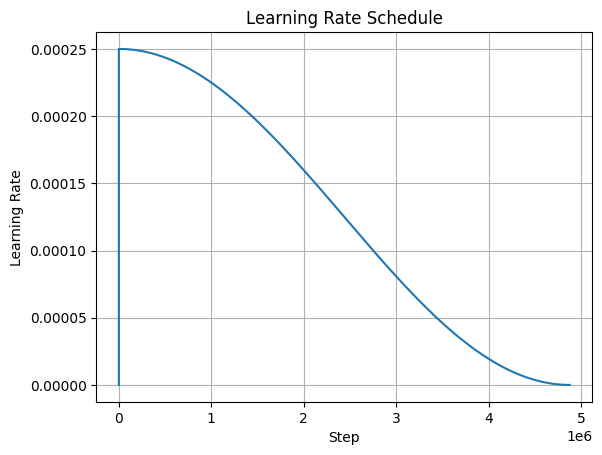

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from transformers import get_cosine_schedule_with_warmup

# dummy optimizer
optimizer = optim.AdamW(
    [torch.nn.Parameter(torch.randn((4, 4)))],
    lr=config.PretrainConfig.lr,
)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_training_steps=total_steps,
    num_warmup_steps=warmup_steps,
)

lrs = []
for step in range(total_steps):
    optimizer.step()
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

plt.plot(range(len(lrs)), lrs)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()

### 3.3 Train Loop
Let's recall the training objective of language model, given a sequence of tokens $ x_1, x_2, \ldots, x_T $ from data loader, the model is trained to predict each token $ x_t $ conditioned on the previous tokens $ x_1, x_2, \ldots, x_{t-1} $:
$$
\mathcal{L} = -\sum_{t=1}^{T} \log P(x_t | x_1, x_2, \ldots, x_{t-1}; \theta)
$$

where $ \theta $ represents the model parameters. 

Considering the GPU memory constraints, gradient accumulation is needed to ensure sufficient tokens in each batch, updating gradients every `update_freq` rounds.

In [ ]:
from tqdm.notebook import tqdm
import torch.nn as nn


def split_batch(batch):
    src, tgt = batch[:, :-1], batch[:, 1:]
    return src.to(device), tgt.to(device)


def train(epoch, model, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0
    step = 0
    optimizer.zero_grad()

    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch}"):
        src, tgt = split_batch(batch)

        # [batch_size, max_len - 1, vocab_size]
        outputs = model(src)

        # [batch_size * (max_len - 1), vocab_size]
        outputs = outputs.contiguous().view(-1, tokenizer.get_vocab_size())
        loss = criterion(outputs, tgt.contiguous().view(-1))
        loss.backward()

        if (step + 1) % config.PretrainConfig.update_freq == 0 or (step + 1) == len(
            dataloader
        ):
            nn.utils.clip_grad_norm_(model.parameters(), config.clip)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        step += 1
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)

    return avg_loss

In [ ]:
import os


def training_loop(restore_epoch=-1):
    optimizer = model.configure_optimizers(
        lr=config.PretrainConfig.lr,
        weight_decay=config.weight_decay,
        device_type="cuda",
    )
    scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_training_steps=total_steps,
        num_warmup_steps=warmup_steps,
    )
    criterion = nn.CrossEntropyLoss()

    restore_ckpt_path = config.checkpoint_dir / f"gpt_{restore_epoch}.pth"
    if restore_epoch != -1 and os.path.exists(restore_ckpt_path):
        ckpt = torch.load(restore_ckpt_path)
        assert ckpt["epoch"] == restore_epoch
        model.load_state_dict(ckpt["model"])
        optimizer.load_state_dict(ckpt["optimizer"])
        scheduler.load_state_dict(ckpt["scheduler"])
    else:
        restore_epoch = 0

    for epoch in range(restore_epoch, config.PretrainConfig.n_epoch):
        avg_train_loss = train(epoch + 1, model, criterion, optimizer, scheduler)
        print(
            f"Epoch {epoch + 1}/{config.PretrainConfig.n_epoch}, Training Loss: {avg_train_loss: .4f}"
        )

        checkpoint_path = config.checkpoint_dir / f"gpt_{epoch + 1}.pth"
        torch.save(
            {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
            },
            checkpoint_path,
        )


training_loop()